In [1]:
from pathlib import Path
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy as sp
import warnings
warnings.filterwarnings("ignore")
%xmode minimal

Exception reporting mode: Minimal


In [208]:
def save_predictions(id_series, predictions):
    with open("submission.csv", "w") as f:
        f.write("Id,SalePrice\n")
        for i, val in zip(id_series, predictions):
            f.write(f"{i},{val:0.12e}\n")

# Regression for House Prices Project

Notebook for the house price regression analysis. What this notebook should do:
1. Read in the data
2. Clean the data
3. Explore what features are good for use in the project and prune the irrelavant ones
4. Perform simple analyses to determine the importance of the remaining features
5. Use and compare the performance of multiple models in the regression task. These should include:
   * Linear Regression: with L1, L2 and (L1 + L2) regularization
   * An XGBoost Regressor
   * A Deep Neural Network

## Step 1: read in the data and do some clean up
Read in the data, and do very simple cleaning of the column names

In [2]:
input_path = Path("../data")
train = pd.read_csv(input_path / "train.csv")
test = pd.read_csv(input_path / "test.csv")

In [3]:
Y = train.pop("SalePrice")

In [4]:
train.columns = train.columns.str.replace(" ","") ## replace the white space (one or two columns have it)
test.columns = test.columns.str.replace(" ","")

In [5]:
## how many items in train and test?
print(f"{train.shape = }, {test.shape = }")

train.shape = (1460, 80), test.shape = (1459, 80)


In [6]:
## concatenate the two data frames into a master one for preprocessing:
train_id, test_id = train.Id, test.Id
train_copy = train.drop("Id", axis=1).copy()
test_copy = test.drop("Id", axis=1).copy()
df = pd.concat([train_copy, test_copy], axis=0, sort=False)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2919 entries, 0 to 1458
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   int64  
 1   MSZoning       2915 non-null   object 
 2   LotFrontage    2433 non-null   float64
 3   LotArea        2919 non-null   int64  
 4   Street         2919 non-null   object 
 5   Alley          198 non-null    object 
 6   LotShape       2919 non-null   object 
 7   LandContour    2919 non-null   object 
 8   Utilities      2917 non-null   object 
 9   LotConfig      2919 non-null   object 
 10  LandSlope      2919 non-null   object 
 11  Neighborhood   2919 non-null   object 
 12  Condition1     2919 non-null   object 
 13  Condition2     2919 non-null   object 
 14  BldgType       2919 non-null   object 
 15  HouseStyle     2919 non-null   object 
 16  OverallQual    2919 non-null   int64  
 17  OverallCond    2919 non-null   int64  
 18  YearBuilt    

In [8]:
df.head(3)

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0          60       RL         65.0     8450   Pave   NaN      Reg   
1          20       RL         80.0     9600   Pave   NaN      Reg   
2          60       RL         68.0    11250   Pave   NaN      IR1   

  LandContour Utilities LotConfig  ... ScreenPorch PoolArea PoolQC Fence  \
0         Lvl    AllPub    Inside  ...           0        0    NaN   NaN   
1         Lvl    AllPub       FR2  ...           0        0    NaN   NaN   
2         Lvl    AllPub    Inside  ...           0        0    NaN   NaN   

  MiscFeature MiscVal  MoSold  YrSold  SaleType  SaleCondition  
0         NaN       0       2    2008        WD         Normal  
1         NaN       0       5    2007        WD         Normal  
2         NaN       0       9    2008        WD         Normal  

[3 rows x 79 columns]

To determine what columns to keep, a simple task is to look at all the missing data in the data set. If there are any columns that are majority *NaN*, then they would not be particulary instructive. This may even signal that a column like that exists in the test set only and thus we are not actually able to include it in the training. 

In [9]:
len_train = train.shape[0]
threshold_missing_cut = 20
nan = pd.DataFrame(df.isna().sum(), columns = ['NaN_sum'])
nan['feat'] = nan.index
nan['Perc(%)'] = (nan['NaN_sum']/len_train)*100
nan = nan[nan['NaN_sum'] > 0]
nan = nan.sort_values(by = ['NaN_sum'])
nan['Usability'] = np.where(nan['Perc(%)'] > threshold_missing_cut, 'Discard', 'Keep')
nan

NaN_sum          feat     Perc(%) Usability
TotalBsmtSF         1   TotalBsmtSF    0.068493      Keep
GarageArea          1    GarageArea    0.068493      Keep
GarageCars          1    GarageCars    0.068493      Keep
KitchenQual         1   KitchenQual    0.068493      Keep
Electrical          1    Electrical    0.068493      Keep
BsmtUnfSF           1     BsmtUnfSF    0.068493      Keep
BsmtFinSF2          1    BsmtFinSF2    0.068493      Keep
BsmtFinSF1          1    BsmtFinSF1    0.068493      Keep
SaleType            1      SaleType    0.068493      Keep
Exterior1st         1   Exterior1st    0.068493      Keep
Exterior2nd         1   Exterior2nd    0.068493      Keep
Functional          2    Functional    0.136986      Keep
Utilities           2     Utilities    0.136986      Keep
BsmtHalfBath        2  BsmtHalfBath    0.136986      Keep
BsmtFullBath        2  BsmtFullBath    0.136986      Keep
MSZoning            4      MSZoning    0.273973      Keep
MasVnrArea         23    MasVnrArea    1.575342      Keep
BsmtFinType1       79  BsmtFinType1    5.410959      Keep
BsmtFinType2       80  BsmtFinType2    5.479452      Keep
BsmtQual           81      BsmtQual    5.547945      Keep
BsmtCond           82      BsmtCond    5.616438      Keep
BsmtExposure       82  BsmtExposure    5.616438      Keep
GarageType        157    GarageType   10.753425      Keep
GarageCond        159    GarageCond   10.890411      Keep
GarageQual        159    GarageQual   10.890411      Keep
GarageYrBlt       159   GarageYrBlt   10.890411      Keep
GarageFinish      159  GarageFinish   10.890411      Keep
LotFrontage       486   LotFrontage   33.287671   Discard
FireplaceQu      1420   FireplaceQu   97.260274   Discard
MasVnrType       1766    MasVnrType  120.958904   Discard
Fence            2348         Fence  160.821918   Discard
Alley            2721         Alley  186.369863   Discard
MiscFeature      2814   MiscFeature  192.739726   Discard
PoolQC           2909        PoolQC  199.246575   Discard

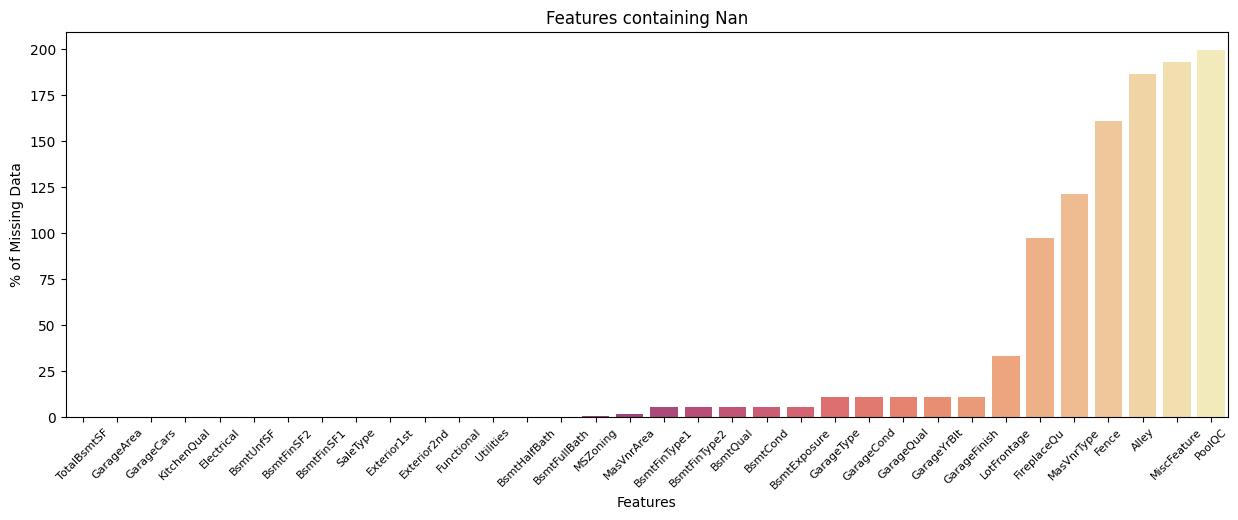

In [10]:
plt.figure(figsize = (15,5))
sns.barplot(x = nan['feat'], y = nan['Perc(%)'], palette="magma")
plt.xticks(rotation=45, fontsize=8)
plt.title('Features containing Nan')
plt.xlabel('Features')
plt.ylabel('% of Missing Data')
plt.show()

Create a list of features to drop, based on a threshold cut. If the number of nan's is more than this threshold, cut them off.

In [11]:
columns_to_drop = list(nan[nan["Usability"] == "Discard"]["feat"].values)
columns_to_drop

['LotFrontage',
 'FireplaceQu',
 'MasVnrType',
 'Fence',
 'Alley',
 'MiscFeature',
 'PoolQC']

Now we can proceed with cleaning what is left.

In [12]:
# Convert non-numerics to strings

df['MSSubClass'] = df['MSSubClass'].apply(str)
df['YrSold'] = df['YrSold'].apply(str)
df['MoSold'] = df['MoSold'].apply(str)

# Filling Categorical NaN. Basically go with the _average_

df["Functional"]  = df["Functional"].fillna("Typ")
df["Electrical"]  = df["Electrical"].fillna("SBrkr")
df["KitchenQual"] = df["KitchenQual"].fillna("TA")
df["Exterior1st"] = df["Exterior1st"].fillna(df["Exterior1st"].mode()[0])
df["Exterior2nd"] = df["Exterior2nd"].fillna(df["Exterior2nd"].mode()[0])
df["SaleType"]    = df["SaleType"].fillna(df["SaleType"].mode()[0])

for col in ('GarageArea', 'GarageCars'):
    df[col] = df[col].fillna(0)
        
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    df[col] = df[col].fillna('None')
    
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    df[col] = df[col].fillna('None')
    
# for col in ("BstmFinSF1", "BstmFinSF2", "BstmUnfSF", "BstmFullBath", "BstmHalfBath"):
#     df[col] = df[col].fillna(0)
df["GarageYrBlt"] = df["GarageYrBlt"].where(df.GarageYrBlt.notna(), df.YearBuilt)

# Checking the features with NaN remained out
cols_to_check = []
for col in df:
    if df[col].isna().sum() > 0:
        print(col,"\n", df[col].isna().sum())
        cols_to_check.append(col)

MSZoning 
 4
LotFrontage 
 486
Alley 
 2721
Utilities 
 2
MasVnrType 
 1766
MasVnrArea 
 23
BsmtFinSF1 
 1
BsmtFinSF2 
 1
BsmtUnfSF 
 1
TotalBsmtSF 
 1
BsmtFullBath 
 2
BsmtHalfBath 
 2
FireplaceQu 
 1420
PoolQC 
 2909
Fence 
 2348
MiscFeature 
 2814


In [13]:
tmp = df[df["MasVnrArea"].isna()][["MasVnrArea","MasVnrType"]]
tmp

MasVnrArea MasVnrType
234          NaN        NaN
529          NaN        NaN
650          NaN        NaN
936          NaN        NaN
973          NaN        NaN
977          NaN        NaN
1243         NaN        NaN
1278         NaN        NaN
231          NaN        NaN
246          NaN        NaN
422          NaN        NaN
532          NaN        NaN
544          NaN        NaN
581          NaN        NaN
851          NaN        NaN
865          NaN        NaN
880          NaN        NaN
889          NaN        NaN
908          NaN        NaN
1132         NaN        NaN
1197         NaN        NaN
1226         NaN        NaN
1402         NaN        NaN

In [14]:
## so replace the NaN's of the MasVnrArea with 0
df["MasVnrArea"].fillna(0, inplace=True)

In [15]:
tmp = df[df["Utilities"].isna()][["Utilities","Street","Condition1","Condition2"]]
tmp

Utilities Street Condition1 Condition2
455       NaN   Grvl       Norm       Norm
485       NaN   Pave      Feedr       Norm

In [16]:
## based on the above, put utilities as "AllPub"
df["Utilities"].fillna("AllPub", inplace=True)

In [17]:
# # mask = df.columns[df.columns.str.contains('Bsmt')]
# tmp = df[df["BsmtFinSF1"].isna()][mask]
# tmp

In [18]:
for i in [1, 2]:
    df[f"BsmtFinSF{i}"] = df[f"BsmtFinSF{i}"].where(df[f"BsmtFinType{i}"] != "None", 0.0)
    
for col in ["BsmtUnfSF", "TotalBsmtSF", "BsmtFullBath", "BsmtHalfBath"]:
    df[col].fillna(0.0, inplace=True) 

In [19]:
cols_to_check = []
for col in df:
    message = ""
    if df[col].isna().sum() > 0:
        message = f"{col:>12}, n_null:{df[col].isna().sum(): >5}"
        cols_to_check.append(col)
        if col in columns_to_drop:
            message += "--> don't bother, it's to be dropped"
        print(message)

    MSZoning, n_null:    4
 LotFrontage, n_null:  486--> don't bother, it's to be dropped
       Alley, n_null: 2721--> don't bother, it's to be dropped
  MasVnrType, n_null: 1766--> don't bother, it's to be dropped
 FireplaceQu, n_null: 1420--> don't bother, it's to be dropped
      PoolQC, n_null: 2909--> don't bother, it's to be dropped
       Fence, n_null: 2348--> don't bother, it's to be dropped
 MiscFeature, n_null: 2814--> don't bother, it's to be dropped


It's only 4 missing values for _MSZoning_. I can either just drop all 4, which wouldn't hurt me that much. But just generally, maybe a good idea to replace with the most common category. In the real world, it's a good idea to go and check the official records and fix the issue.

In [20]:
df["MSZoning"] = df.MSZoning.where(df.MSZoning.notna(), df.MSZoning.mode()[0])

In [21]:
cols_to_check = []
for col in df:
    message = ""
    if df[col].isna().sum() > 0:
        message = f"{col:>12}, n_null:{df[col].isna().sum(): >5}"
        cols_to_check.append(col)
        if col in columns_to_drop:
            message += "--> don't bother, it's to be dropped"
        print(message)

 LotFrontage, n_null:  486--> don't bother, it's to be dropped
       Alley, n_null: 2721--> don't bother, it's to be dropped
  MasVnrType, n_null: 1766--> don't bother, it's to be dropped
 FireplaceQu, n_null: 1420--> don't bother, it's to be dropped
      PoolQC, n_null: 2909--> don't bother, it's to be dropped
       Fence, n_null: 2348--> don't bother, it's to be dropped
 MiscFeature, n_null: 2814--> don't bother, it's to be dropped


In [22]:
df.drop(labels=columns_to_drop, inplace=True, axis=1)

## Step 2: feature engineering
Let's add a few features that a person on the market would probably care about. Some of these I myself found important or interesting to know.

In [23]:
# Add a couple of features:
df["AreaWithBasement"]   = np.float64(pd.to_numeric(df["TotalBsmtSF"]) + pd.to_numeric(df["GrLivArea"]))
df["SqFtPerRoom"]        = df["GrLivArea"] / (df["TotRmsAbvGrd"] + df["FullBath"] + df["HalfBath"] + df["KitchenAbvGr"])
df["Total_Home_Quality"] = df['OverallQual'] + df['OverallCond']
df["Total_Bathrooms"]    = df['FullBath'] + (0.5 * df['HalfBath']) + df['BsmtFullBath'] + (0.5 * df['BsmtHalfBath'])
df["AgeAtSale"]          = pd.to_numeric(df["YrSold"])-pd.to_numeric(df["YearBuilt"])
df["TimeSinceRenov"]     = pd.to_numeric(df["YearRemodAdd"])-pd.to_numeric(df["YearBuilt"])

## Step 3: correct data types, split back to train and test

Construct lists of:
1. numbered features (real numbers like area)
2. ordinal categorical features where the order of the category is meaningful (good vs bad vs worse)
3. nominal categorical features where we have categories but assigning value to each category is meaningless or misleading

In [113]:
nominal_features = [
    "MSSubClass",
    "MSZoning",
    "Street",
    "Utilities",
    "LotConfig",
    "Neighborhood",
    "Condition1",
    "Condition2",
    "BldgType",
    "HouseStyle",
    "RoofStyle",
    "RoofMatl",
    "Exterior1st",
    "Exterior2nd",
    "Foundation",
    "Heating",
    "Electrical",
    "GarageType",
    "SaleType",
    "SaleCondition",
    "CentralAir",
    "MoSold"
]

## ordered categories:
ten_levels = list(range(10))
five_levels = ["Po", "Fa", "TA", "Gd", "Ex"]

ordinal_features = {
    "OverallQual": ten_levels,
    "OverallCond": ten_levels,
    "ExterCond": five_levels,
    "ExterQual": five_levels,
    "BsmtQual": five_levels,
    "BsmtCond": five_levels,
    "BsmtExposure": five_levels,
    "HeatingQC": five_levels,
    "KitchenQual": five_levels,
    "GarageQual": five_levels,
    "GarageCond": five_levels,
    "BsmtFinType1": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "BsmtFinType2": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "GarageFinish": ["Unf", "RFn", "Fin"],
    "PavedDrive": ["N", "P", "Y"],
    "LandSlope": ["Sec", "Mod", "Gtl"],
    "LotShape": ["Reg", "IR1", "IR2", "IR3"],
    "LandContour": ["Lvl", "Bnk", "HLS", "Low"],
    "Electrical": ["Mix", "FuseP", "FuseF", "FuseA", "SBrkr"],
    "Functional": ["Sal", "Sev", "Maj2", "Maj1", "Mod", "Min2", "Min1", "Typ"],
}
## Add a _none_ level for each of the above, to catch missing values
ordinal_features = {
    key: ["None"] + value for key, value in ordinal_features.items()
}

## real-valued columns:
numerical_features = [
    "LotArea",
    "MasVnrArea",
    "BsmtFinSF1",
    "BsmtFinSF2",
    "BsmtUnfSF",
    "TotalBsmtSF",
    "1stFlrSF",
    "2ndFlrSF",
    "LowQualFinSF",
    "GrLivArea",
    "GarageArea",
    "WoodDeckSF",
    "OpenPorchSF",
    "EnclosedPorch",
    "3SsnPorch",
    "ScreenPorch",
    "PoolArea",
    "SqFtPerRoom",     
    "Total_Home_Quality",  
    "Total_Bathrooms",     
    "AgeAtSale",           
    "TimeSinceRenov",
    "AreaWithBasement",
    "YearBuilt","YearRemodAdd",
     "FullBath",
     "HalfBath",  
     "BedroomAbvGr",  
     "KitchenAbvGr",  
     "TotRmsAbvGrd",  
     "Fireplaces","MiscVal"  ]

In [114]:
## handle the various features here for the correct type setting

In [115]:
## numerical categories:
for col in numerical_features:
    df[col] = (1.0*df[col]).astype(np.float64)
## nominal features
for col in nominal_features:
    df[col] = df[col].astype("category")
## ordinal features:
for col in ordinal_features:
    df[col] = df[col].astype("category")
    # if "None" not in df[col].cat.categories:
    #     df[col] = df[col].cat.add_categories("None")
      

In [116]:
df_cats = df.select_dtypes("category")

In [117]:
df_cats.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2919 entries, 0 to 1458
Data columns (total 41 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   MSSubClass     2919 non-null   category
 1   MSZoning       2919 non-null   category
 2   Street         2919 non-null   category
 3   LotShape       2919 non-null   category
 4   LandContour    2919 non-null   category
 5   Utilities      2919 non-null   category
 6   LotConfig      2919 non-null   category
 7   LandSlope      2919 non-null   category
 8   Neighborhood   2919 non-null   category
 9   Condition1     2919 non-null   category
 10  Condition2     2919 non-null   category
 11  BldgType       2919 non-null   category
 12  HouseStyle     2919 non-null   category
 13  OverallQual    2919 non-null   category
 14  OverallCond    2919 non-null   category
 15  RoofStyle      2919 non-null   category
 16  RoofMatl       2919 non-null   category
 17  Exterior1st    2919 non-null   categor

In [118]:
df_num = df.select_dtypes("number")

In [119]:
df_num.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2919 entries, 0 to 1458
Data columns (total 36 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   LotArea             2919 non-null   float64
 1   YearBuilt           2919 non-null   float64
 2   YearRemodAdd        2919 non-null   float64
 3   MasVnrArea          2919 non-null   float64
 4   BsmtFinSF1          2919 non-null   float64
 5   BsmtFinSF2          2919 non-null   float64
 6   BsmtUnfSF           2919 non-null   float64
 7   TotalBsmtSF         2919 non-null   float64
 8   1stFlrSF            2919 non-null   float64
 9   2ndFlrSF            2919 non-null   float64
 10  LowQualFinSF        2919 non-null   float64
 11  GrLivArea           2919 non-null   float64
 12  BsmtFullBath        2919 non-null   float64
 13  BsmtHalfBath        2919 non-null   float64
 14  FullBath            2919 non-null   float64
 15  HalfBath            2919 non-null   float64
 16  BedroomAbvG

In [120]:
train = df[:len_train]
test = df[len_train:]

## Step 4: few plots, pipeline creation

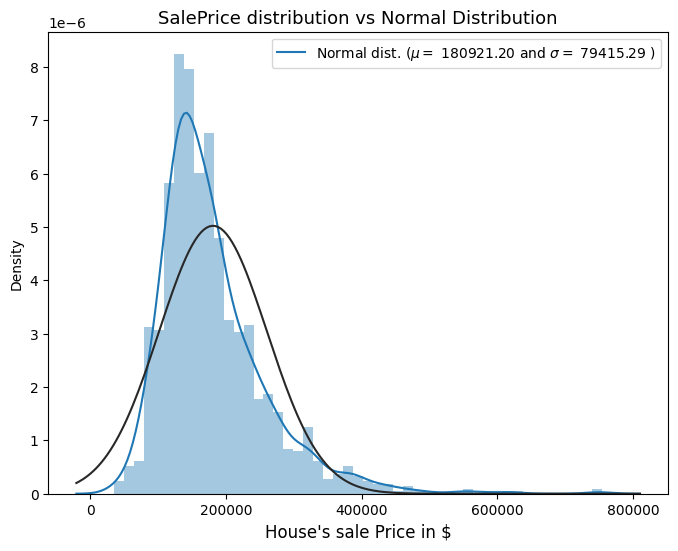

In [121]:
# Getting the main parameters of the Normal Ditribution ()
(mu, sigma) = sp.stats.norm.fit(Y)

fig, ax = plt.subplots(1,1, figsize = (8,6))

sns.distplot(Y, kde = True, hist=True, fit = sp.stats.norm)
ax.set_title('SalePrice distribution vs Normal Distribution', fontsize = 13)
ax.set_xlabel("House's sale Price in $", fontsize = 12)
ax.legend(["Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )".format(mu, sigma)],
            loc='best')
plt.show()

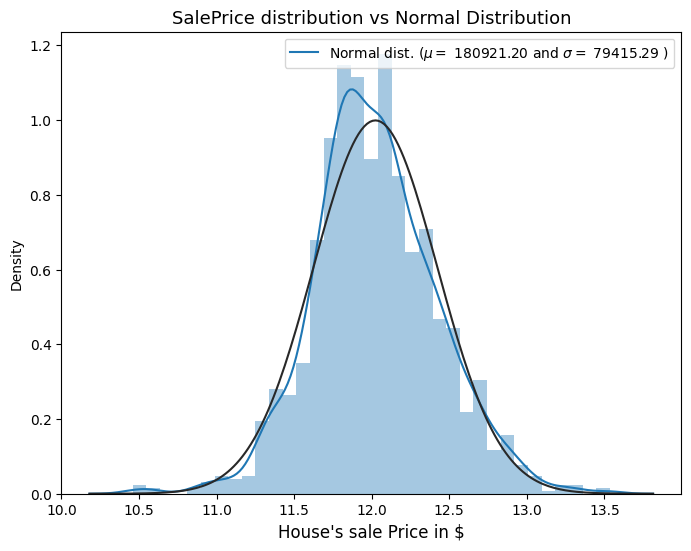

In [122]:
fig, ax = plt.subplots(1,1, figsize = (8,6))
Y_log = np.log1p(Y)
sns.distplot(Y_log, kde = True, hist=True, fit = sp.stats.norm)
ax.set_title('SalePrice distribution vs Normal Distribution', fontsize = 13)
ax.set_xlabel("House's sale Price in $", fontsize = 12)
ax.legend(["Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )".format(mu, sigma)],
            loc='best')
plt.show()

So if we aim for the $\log\left(1+\mathrm{SalePrice}\right)$, we are probably going to do better since the distribution better resembles a normal distribution. See [this post on math.stackexchange.com](https://math.stackexchange.com/questions/3245046/advantage-of-inputs-targets-to-be-normally-distributed). For the numerical features, I will follow a similar prescription, using _sklearn.preprocessing.PowerTransformer_ which provides the functionality to map a feature to a Gaussian Distribution. Using the _standardize_ feature of this transformer, we can also ensure that our numerical features acquire a normal (or close to normal) distribution.

In [123]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn import set_config
set_config(transform_output="pandas")
colTransformer = ColumnTransformer(
    [
        ("numerictrans", PowerTransformer(method='yeo-johnson', standardize=True, copy=True), numerical_features),
        ("ordinaltrans", OrdinalEncoder(), list(ordinal_features.keys())),
        ("nominaltrans", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), nominal_features)
    ]
)

In [124]:
X_train = colTransformer.fit_transform(train)

In [125]:
numeric_cols = ["numerictrans__" + name for name in numerical_features]

In [126]:
X_test = colTransformer.transform(test)

In [127]:
sns.pairplot(data=X_train, x_vars=numeric_cols, y_vars=numeric_cols, corner=True)

In [387]:
transformed_df = X_train.copy()
transformed_df["SalePrice"] = Y_log

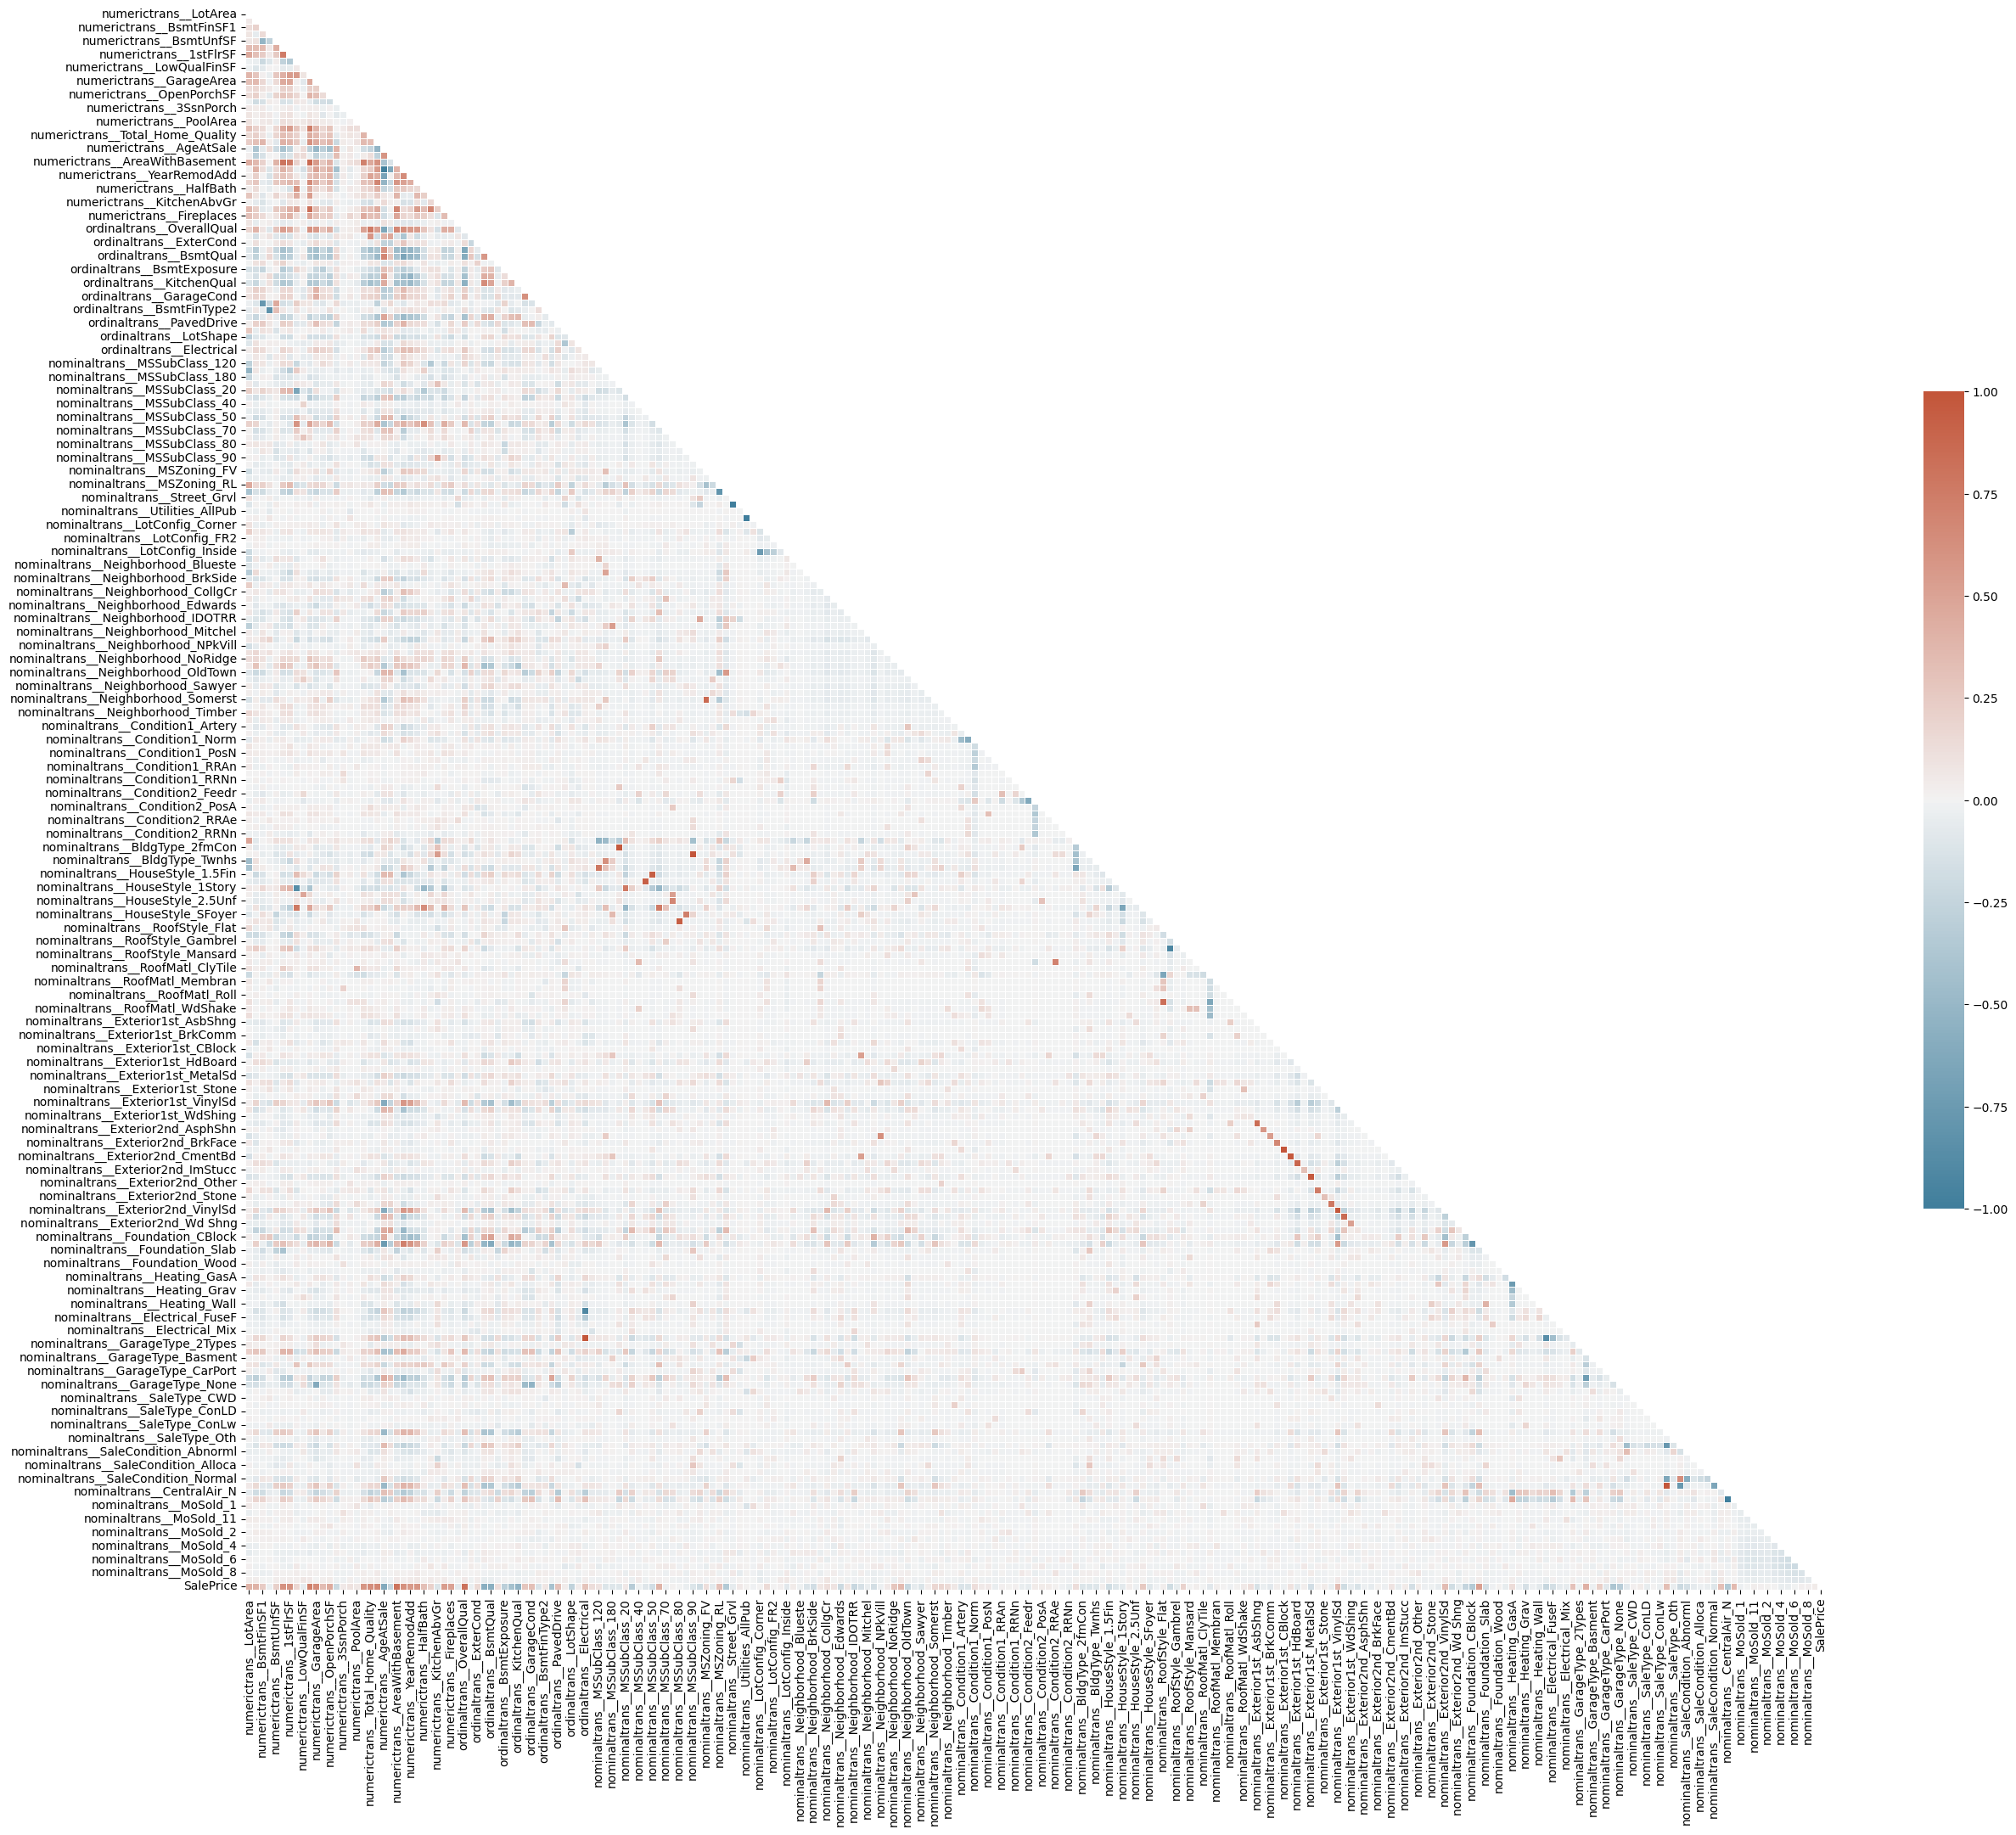

In [389]:
# Correlation Matrix

f, ax = plt.subplots(figsize=(30, 25))
mat = transformed_df.corr('pearson')
mask = np.triu(np.ones_like(mat, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(mat, mask=mask, cmap=cmap, vmax=1, center=0, annot = False,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [390]:
correlations = transformed_df.corrwith(transformed_df["SalePrice"], method='pearson')

In [397]:
correlations.sort_values(ascending=False, inplace=True)
cut = correlations[abs(correlations) > 0.2] 

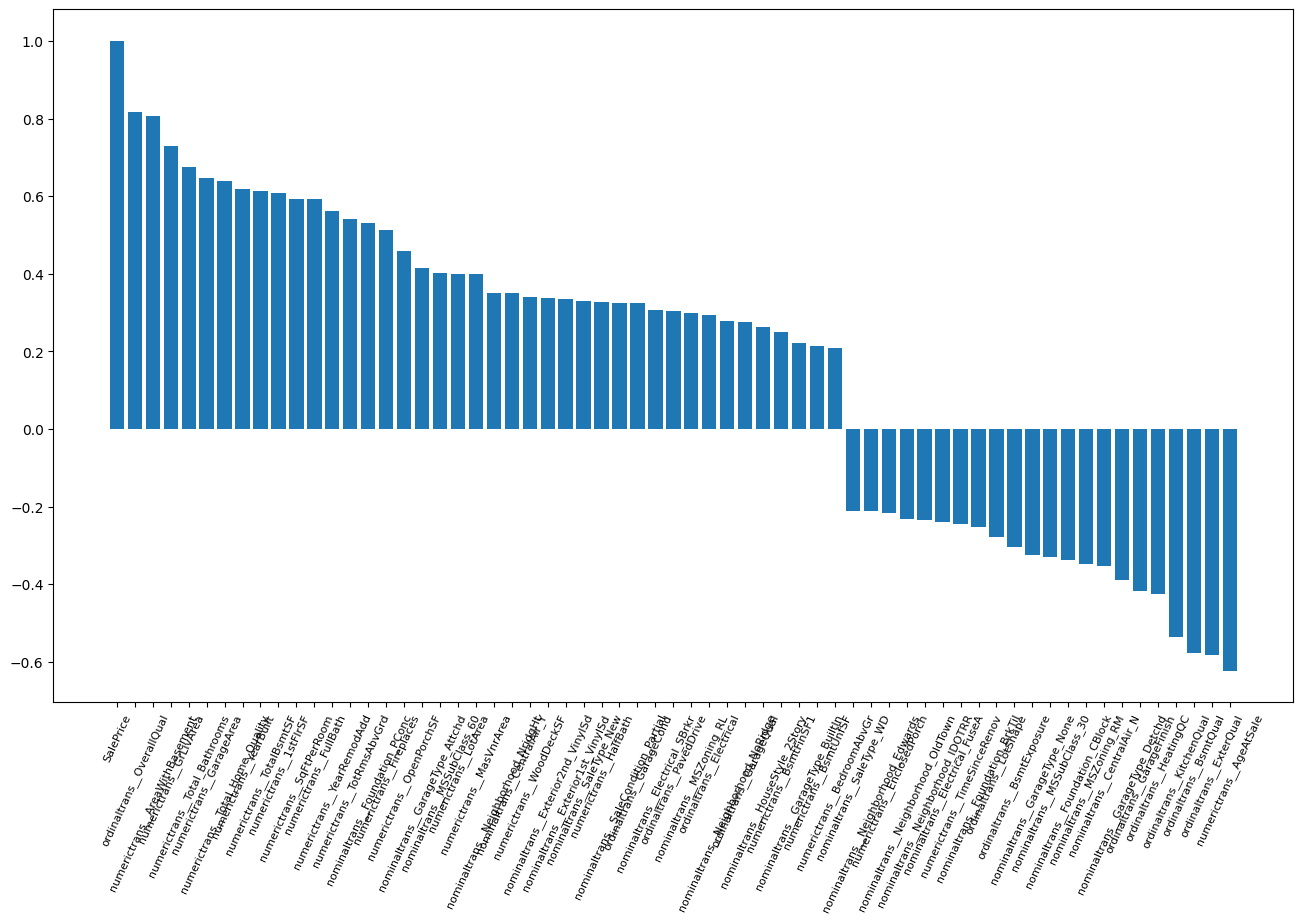

In [406]:
fig, ax = plt.subplots(1,1, figsize=(16,9))
ax.bar(cut.index, cut.values)
_=ax.set_xticklabels(ax.get_xticklabels(), rotation=65, fontsize=8)

## Step 5: Modelling

In [183]:
from sklearn import linear_model 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import root_mean_squared_error
from xgboost import XGBRegressor
from tensorflow import keras

### Model 1: Simple Linear Regression
A Simple linear model, assuming that the _SalePrice_ is a simple linear combination of all the features.

In [133]:
model_1 = linear_model.LinearRegression()
simple_linear_scores = cross_val_score(X=X_train, y=Y_log, estimator=model_1, cv=10, scoring="neg_root_mean_squared_error")

In [134]:
print(f"mean:{simple_linear_scores.mean()}, std:{simple_linear_scores.std()}")

mean:-621970372.5671351, std:571158670.5278387


In [161]:
model_2 = linear_model.Ridge()
ridge_scores = cross_val_score(X=X_train, y=Y_log, estimator=model_2, cv=10, scoring="neg_root_mean_squared_error")

In [162]:
print(f"mean:{ridge_scores.mean()}, std:{ridge_scores.std()}")

mean:-0.12612001588075594, std:0.024486433616451617


In [166]:
model_2.fit(X_train, Y_log)
predictions = np.expm1(model_2.predict(X_test))

In [167]:
print(predictions)

[127480.63612734 161648.16224655 182554.086385   ... 163282.75301236
 120308.40950234 218353.90474295]


In [169]:
with open("submission.csv", "w") as f:
    f.write("Id,SalePrice\n")
    for i, val in zip(test_id, predictions):
        f.write(f"{i},{val:0.12e}\n")

In [177]:
model_3 = linear_model.ElasticNet(l1_ratio=0.007)
elasticnet_scores = cross_val_score(X=X_train, y=Y_log, estimator=model_3, cv=10, scoring="neg_root_mean_squared_error")
print(f"mean:{elasticnet_scores.mean()}, std:{elasticnet_scores.std()}")

mean:-0.14453416190609913, std:0.01959467272333368


So it seems that Ridge Regression did the best in the above. Now let's explore XGBRegressor. 

In [180]:
model_4 = XGBRegressor(n_estimators=5000, max_depth=6, eta=0.1, subsample=0.75, colsample_bytree=0.85)
boosted_tree_scores = cross_val_score(X=X_train, y=Y_log, estimator=model_4, cv=10, scoring="neg_root_mean_squared_error")
print(f"mean:{boosted_tree_scores.mean()}, std:{boosted_tree_scores.std()}")

mean:-0.12545712589515776, std:0.01628660720525977


In [181]:
model_4.fit(X_train, Y_log)
predictions = np.expm1(model_4.predict(X_test))

In [182]:
with open("submission.csv", "w") as f:
    f.write("Id,SalePrice\n")
    for i, val in zip(test_id, predictions):
        f.write(f"{i},{val:0.12e}\n")

In [204]:
param_grid = {"n_estimators" : [1_000, 2_000, 3_000, 3_500],
              "max_depth" : [4,6,8,10],
              "eta" : [0.5, 0.1, 0.05, 0.01]}
              # "subsample" : [0.5, 0.6, 0.7, 0.8, 1.0],
              # "colsample_bytree": [0.5, 0.6, 0.7, 0.8, 1.0]}
model_4 = XGBRegressor(subsample=0.75, colsample_bytree=0.75)

In [206]:
gridsearcher_xgboost_regressor = GridSearchCV(model_4, param_grid, scoring="neg_root_mean_squared_error", cv=5, verbose=3)
gridsearcher_xgboost_regressor.fit(X_train, Y_log)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 1/5] END eta=0.5, max_depth=4, n_estimators=1000;, score=-0.141 total time=   0.9s
[CV 2/5] END eta=0.5, max_depth=4, n_estimators=1000;, score=-0.168 total time=   0.9s
[CV 3/5] END eta=0.5, max_depth=4, n_estimators=1000;, score=-0.158 total time=   0.8s
[CV 4/5] END eta=0.5, max_depth=4, n_estimators=1000;, score=-0.142 total time=   0.9s
[CV 5/5] END eta=0.5, max_depth=4, n_estimators=1000;, score=-0.154 total time=   0.8s
[CV 1/5] END eta=0.5, max_depth=4, n_estimators=2000;, score=-0.141 total time=   1.5s
[CV 2/5] END eta=0.5, max_depth=4, n_estimators=2000;, score=-0.168 total time=   1.5s
[CV 3/5] END eta=0.5, max_depth=4, n_estimators=2000;, score=-0.158 total time=   1.4s
[CV 4/5] END eta=0.5, max_depth=4, n_estimators=2000;, score=-0.142 total time=   1.4s
[CV 5/5] END eta=0.5, max_depth=4, n_estimators=2000;, score=-0.154 total time=   1.4s
[CV 1/5] END eta=0.5, max_depth=4, n_estimators=3000;, score=-0.141 

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=0.75, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'eta': [0.5, 0.1, 0.05, 0.01],
                         'max_depth': [4, 6, 8, 10],
                         'n_estimators': [1000, 2000, 3000, 3500]},
             scoring='neg_root_mean_squared_error', verbose=3)

In [209]:
model_5 = gridsearcher_xgboost_regressor.best_estimator_
best_score_ = gridsearcher_xgboost_regressor.best_score_
print(f"best score: {best_score_:0.3f}")

best score: -0.119


In [210]:
predictions = np.expm1(model_5.predict(X_test))

In [211]:
save_predictions(test_id, predictions)

This last one gave a test score of _0.12518_ on Kaggle, so far my best result. Now let's try neural networks!

In [217]:
X_train.shape

(1460, 234)

In [381]:
keras.backend.clear_session()

In [382]:
model_6 = keras.Sequential([
    keras.layers.Dense(activation="softplus", units=512, input_shape=(X_train.shape[1],),),
    keras.layers.Dense(activation="relu", units=256),
    keras.layers.Dense(activation="relu", units=128),
    keras.layers.Dense(activation="relu", units=64),
    keras.layers.Dense(activation="linear",units=1)
])

In [383]:
model_6.compile(optimizer="Adam", loss="mean_squared_error")

In [384]:
model_6.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │       120,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 292,865 (1.12 MB)

 Trainable params: 292,865 (1.12 MB)

 Non-trainable params: 0 (0.00 B)

In [385]:
history = model_6.fit(X_train, Y_log, batch_size=1024, epochs=100, validation_split=0.15)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 129.5265 - val_loss: 45.1854
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 35.2694 - val_loss: 0.5338
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 3.3335 - val_loss: 20.1922
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 19.0589 - val_loss: 8.4437
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 6.1422 - val_loss: 0.1771
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.7948 - val_loss: 4.6446
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 5.1005 - val_loss: 5.1346
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 4.5765 - val_loss: 1.3729
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.0013 - val_loss: 0.3205
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.5459 - val_loss: 2.2965
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2.2178 - val_loss: 1.9646
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.5084 - 

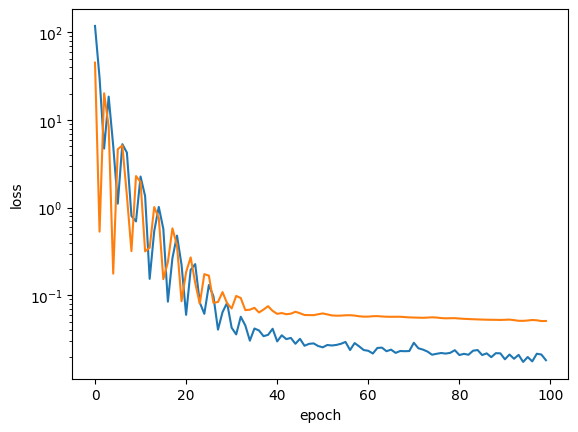

In [386]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')
plt.show()

In [377]:
predictions = np.expm1(model_6.predict(X_test))

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [378]:
predictions = predictions.reshape(1,-1)[0]

In [379]:
save_predictions(test_id, predictions)